# <div align="center"><b> TRANSFORMERS PARA SERIES DE TIEMPO </b></div>

<div align="right">📝 <em><small><font color='Gray'>Nota:</font></small></em></div>

<div align="right"> <em><small><font color='Gray'> La funcionalidad de visualización de jupyter notebooks en <a href="https://github.com/" target="_blank">github</a> es solamente un preview.</font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Para mejor visualización se sugiere utilizar el visualizador recomendado por la comunidad: <a href="https://nbviewer.org/" target="_blank">nbviewer</a></font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Puedes a acceder al siguiente enlace para ver este notebook en dicha página: <a href="https://nbviewer.org/github/brunomaso1/uba-mia/blob/mia-ast2/mia-ast2/TPFinal.ipynb">Ruta archivo</a></font></small></em> </div>

* * *

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>

🛻 <em><font color='MediumSeaGreen'>  Instalaciones: </font></em> 🛻

Este notebook utiliza [Poetry](https://python-poetry.org/) para la gestión de dependencias.
Primero instala Poetry siguiendo las instrucciones de su [documentación oficial](https://python-poetry.org/docs/#installation).
Luego ejecuta el siguiente comando para instalar las dependencias necesarias y activar el entorno virtual:

- Bash:
```bash
poetry install
eval $(poetry env activate)
```

- PowerShell:
```powershell
poetry install
Invoke-Expression (poetry env activate)
```

<!-- Descargar archivos adicionales:
!gdown https://drive.google.com/drive/folders/1UBZ8PEbtmiWMGkULu7GAt3VhUpeTy9l7?usp=sharing --folder -->

✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

import keras
from keras import Input, Model
from keras.layers import (
    LayerNormalization,
    MultiHeadAttention,
    Dropout,
    LayerNormalization,
    Conv1D,
    Dense,
    GlobalAveragePooling1D,
    Layer,
    Embedding
)
from keras.callbacks import EarlyStopping, History
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError

from sklearn import metrics

from typing import Tuple

from pprint import pprint

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [57]:
WINDOW_SIZE = 5
EMMBEDDING_DIM = 8
CALLBACKS_LIST = [EarlyStopping(patience=10, restore_best_weights=True)]

<!-- Colab -->
<!-- <div align="center"><img src="https://drive.google.com/uc?export=view&id=1QSNrTsz1hQbmZwpgwx0qpfpNtLW19Orm" width="600" alt="Figura 1: A data scientist is working on word generation using the Lord of the Rings lore. The image is dark and moody, with a focus on the scientist's computer screen. The screen displays a visualization the one ring, with a map of Middle Earth in the background. - Generada con DALL-E3"></div> -->

<div align="center"><img src="resources/portada.jpeg" width="600" alt="Figura 1: A data scientist playing with convolutional neural networks. - Generada con Microsoft Image Creator"></div>

<div align="center"><small><em>Figura 1: Un científico analizando series de tiempo de mercados financieros utilizando redes neuronales</em></small></div>

<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | Transformers en series de tiempo - Análisis de series temporales 2 - FIUBA                                                             |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | Estudio sobre la aplicación de transformers en series de tiempo                                                                        |
| **Integrantes** | - Bruno Masoller (brunomaso1@gmail.com)</br>- Fabricio Denardi (denardifabricio@gmail.com) </br>- Francisco Rassi (franciscorassi@gmail.com)                                                            |

</div>

## Tabla de Contenidos

* [1. Introducción a los transformers](#chapter1)
* [2. Transformers para series de tiempo](#chapter2)
* [3. Caso práctico](#chapter3)
  * [3.1. Transformer base](#section3_1)
  * [3.2. Transformer + positional encoding](#section3_2)
* [4. Estado del arte](#chapter4)
  * [4.1 Caso de uso: Informer](#section_4_1)
* [5. Conclusiones](#chapter5)

## 1. Introducción a los transformers <a class="anchor" id="chapter1"></a>

Explicar `MultiHeadAttention` de Keras.

Explicar como nota la capa Conv1D

## 2. Transformers para series de tiempo <a class="anchor" id="chapter2"></a>

La predicción de series de tiempo enfrenta varios desafíos debido a características de los datos. Usualmente, estos desafíos se asocian con conceptos de estacionaridad, linearidad y naturaleza caotica. Enfoques tradicionales basados en aprendizaje profundo como RNN (*Recurrent Neural Networks*), LSTMs (*Long Short-Term Memory*) o GRU (*Gated Recurrent Units*) procesan los datos de forma secuencial pero son ineficientes para secuencias largas. 

Para superar estos desafíos, una linea a investigar es la aplicación de los *Transformers* a estas secuencias de datos, en base a las ventajas que presentan estas arquitecturas en el procesamiento principalmente de secuencias largas.

- Clasificación según modificaciones en la arquitectura:
  - Modificaciones en "Positional Encoding".
    - Vanilla positional encoding.
    - Learnable positional encoding.
    - Timestamp encoding
  - Modificaciones (optimizaciones) en el módulo de atención.
    - Introducción de sesgo espacial (LogTrans y Pyraformer)
    - Exploración de las propiedades low-rank de la matriz de atención (Informer y FEDformer)
  - Inovación en la arquitectura de la atención
    - Arquitecturas jerárquicas
- Clasificación según el tipo de aplicación.
  - Predicción
    - Predicción de series temporales
        - Variantes a nivel de modelo:
          - Nuevos modulos de atención
            - LogTrans
            - Informer
            - 
          - Novedosas formas de normalizar los datos.
          - Utilización de "bias" para los tokens de entrada.
    - Predicciones temporales-espaciales
    - Predicciones de eventos.
  - Detección de anomalías
  - Clasificación
  - 

Explicar como debe ser la entrada en un transformer para series de tiempo.

## 3. Caso práctico <a class="anchor" id="chapter3"></a>

Esta sección tiene como objetivo presentar un caso práctico de aplicación de transformers a series de tiempo. El enfoque principal se centra en explorar la construcción de modelos de predicción de series temporales utilizando la arquitectura *Transformer*, construídos de forma "manual" utilizando *Keras*.

Se divide en dos partes, por un lado, se realiza la implementación de un modelo *Transformer* desde cero, en donde las entradas son simplemente series de tiempo univariadas. Por otro lado, se explora y analiza una codificación posicional alternativa, que permite incorporar información adicional al modelo.

Para este ejemplo, se utilizará el mismo conjunto de datos que se utilizó en la primera versión de la materia (precio del *Bitcon* obtenido desde Binance), el cual se encuentra disponible en: https://github.com/brunomaso1/uba-mia/tree/mia-ast1/mia-ast1/Trabajo%20final/datasets.

Cargamos el conjunto de datos:

In [3]:
df = pd.read_pickle('resources/BTCUSDT_1D.pkl')
df.head()

,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore
Open Time,,,,,,,,,,,
2024-03-01,61130.99,63114.23,60777.00,62387.90,47737.93473,2024-03-01 23:59:59.999,2.956537e+09,1947444,24195.70252,1.498771e+09,0
2024-03-02,62387.90,62433.19,61561.12,61987.28,25534.73659,2024-03-02 23:59:59.999,1.582567e+09,1641808,12691.37721,7.865831e+08,0
2024-03-03,61987.28,63231.88,61320.00,63113.97,28994.90903,2024-03-03 23:59:59.999,1.804536e+09,1992011,14905.18600,9.278690e+08,0
2024-03-04,63113.97,68499.00,62300.00,68245.71,84835.16005,2024-03-04 23:59:59.999,5.568878e+09,3887853,45319.08640,2.974396e+09,0
2024-03-05,68245.71,69000.00,59005.00,63724.01,132696.78130,2024-03-05 23:59:59.999,8.674527e+09,5310706,65991.84526,4.318206e+09,0


En este caso, nos quedamos solo con la columna de "Close" del conjunto de datos, que representa el precio de cierre de BTC:

In [4]:
df = df[['Close']]
df.head()

,Close
Open Time,
2024-03-01,62387.90
2024-03-02,61987.28
2024-03-03,63113.97
2024-03-04,68245.71
2024-03-05,63724.01


Inicialmente, realizamos un test de estacionaridad, utilizando la prueba de Dickey-Fuller aumentada (ADF). Para ello, generamos una función auxiliar que realice el test:

In [5]:
def test_stationarity(timeseries: pd.DataFrame) -> None:
    """
    Realiza la prueba de Dickey-Fuller aumentada (ADF) para evaluar la estacionaridad de una serie temporal.

    Args:
        timeseries (pd.DataFrame): Serie temporal a evaluar, puede ser un DataFrame o una Serie de pandas.

    Prints:
        Estadístico ADF, valor p y conclusión sobre la estacionaridad de la serie.
    """
    adf_result = adfuller(timeseries)
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])

    if adf_result[1] <= 0.05:
        print("La serie es estacionaria (rechazamos H0)")
    else:
        print("La serie no es estacionaria (no rechazamos H0)")

Realizamos el test:

In [6]:
test_stationarity(df)

ADF Statistic: -1.420856101366877
p-value: 0.5722376131152292
La serie no es estacionaria (no rechazamos H0)


> 📝 <em><font color='Gray'>Nota:</font></em> Se podría realizar otras pruebas como KPSS, no linealidad (BDS), normalidad (Shapiro-Wilks), etc. pero no es el objetivo de este trabajo. Por más información sobre el conjunto de datos, se puede acceder en el siguiente enlace: https://github.com/brunomaso1/uba-mia/blob/mia-ast1/mia-ast1/Trabajo%20final/tp-final.ipynb 

Dividimos el conjunto de datos en entrenamiento y test (también convertimos los datos en listas):

In [7]:
train_size = int(len(df) * 0.9)
df_train, df_test = df[:train_size].values, df[train_size:].values

spots_train, spots_test = df_train.tolist(), df_test.tolist()

print(f"Train size: {len(spots_train)}")
print(f"Test size: {len(spots_test)}")

Train size: 356
Test size: 40


Definimos una función auxiliar para crear las secuencias de datos:

In [8]:
def to_sequences(seq_size: int, obs: list) -> Tuple[np.ndarray, np.ndarray]:
    """
    Genera secuencias de longitud fija y sus correspondientes etiquetas para problemas de series temporales.

    Args:
        seq_size (int): Tamaño de la ventana o longitud de cada secuencia.
        obs (list): Lista de observaciones (puede ser una lista de listas o valores).

    Returns:
        tuple[np.ndarray, np.ndarray]: 
            - x: Array de secuencias de entrada de tamaño (n_samples, seq_size, ...).
            - y: Array de valores objetivo correspondientes a cada secuencia.
    """
    x = [np.array(obs[i : i + seq_size]) for i in range(len(obs) - seq_size)]
    y = [obs[i + seq_size] for i in range(len(obs) - seq_size)]
    return np.array(x), np.array(y)

Creamos las secuencias de datos:

In [9]:
X_train, y_train = to_sequences(WINDOW_SIZE, spots_train)
X_test, y_test = to_sequences(WINDOW_SIZE, spots_test)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (351, 5, 1)
y_train shape: (351, 1)
X_test shape: (35, 5, 1)
y_test shape: (35, 1)


### 3.1. Transformer base <a class="anchor" id="section3_1"></a>

Para la construcción del modelo, se crean dos funciones auxiliares, una que crea el encoder y otra que construye el modelo.

El modelo se construye utilizando la API funcional de `Keras`, donde se define un encoder que utiliza capas de atención y capas densas para procesar las secuencias de datos. El bloque `transformer_encoder` cuenta con:
- Capas de normalización de datos (`LayerNormalization`).
- Capas de atención multi-cabeza (`MultiHeadAttention`).
- Sub-red feed-forward con capas convolucionales (`Conv1D`).
- Capa de dropout para regularización (`Dropout`).
- Conexiones residuales para mejorar el flujo de gradientes.

<!-- TODO: Explicar Conv1D y GlobalAveragePooling1D  como notas -->

Función `transformer_encoder` para crear el encoder:

In [54]:
def transformer_block(
    inputs: keras.layers, head_size: int, num_heads: int, ff_dim: int, dropout: float = 0
) -> keras.layers:
    """
    TODO: Mejorar esta función cambiando a una Layer de Keras personalizada + Test de verificación
    Construye un bloque codificador tipo Transformer.

    Args:
        inputs (keras.Layer): Capa de entrada al encoder.
        head_size (int): Dimensión de cada cabeza de atención.
        num_heads (int): Número de cabezas de atención.
        ff_dim (int): Dimensión de la red feed-forward interna.
        dropout (float, optional): Tasa de dropout. Por defecto 0.

    Returns:
        keras.Layer: Capa de salida del bloque codificador Transformer.
    """
    # Normalización de la entrada
    x = LayerNormalization(epsilon=1e-6)(inputs) # Shape: (batch_size, seq_len, features) -> (batch_size, seq_len, features)

    # Atención multi-cabeza
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x) # Shape: (batch_size, seq_len, features) -> (batch_size, seq_len, features)

    # Conexión residual
    x = Dropout(dropout)(x) # Shape: (batch_size, seq_len, features) -> (batch_size, seq_len, features)
    res = x + inputs  # Shape: (batch_size, seq_len, features) -> (batch_size, seq_len, features)

    # Normalización de la salida
    x = LayerNormalization(epsilon=1e-6)(res) # Shape: (batch_size, seq_len, features) -> (batch_size, seq_len, features)

    # Capa densa feed-forward
    x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x) # Shape: (batch_size, seq_len, features) -> (batch_size, seq_len, ff_dim)
    x = Dropout(dropout)(x) # Shape: (batch_size, seq_len, ff_dim) -> (batch_size, seq_len, ff_dim)

    return Conv1D(filters=inputs.shape[-1], kernel_size=1)(x) + res # Shape: (batch_size, seq_len, ff_dim) -> (batch_size, seq_len, features)

Función `build_model` para construir el modelo:

In [ ]:
def build_model(
    input_shape: tuple,
    head_size: int,
    num_heads: int,
    ff_dim: int,
    num_transformer_blocks: int,
    mlp_units: list,
    dropout: float = 0,
    mlp_dropout: float = 0,
) -> keras.Model:
    """
    Construye un modelo basado en bloques Transformer para series temporales.

    Args:
        input_shape (tuple): Forma de la entrada (longitud de la secuencia, número de características).
        head_size (int): Dimensión de cada cabeza de atención.
        num_heads (int): Número de cabezas de atención en MultiHeadAttention.
        ff_dim (int): Dimensión de la red feed-forward interna de cada bloque Transformer.
        num_transformer_blocks (int): Número de bloques codificadores Transformer a apilar.
        mlp_units (list): Lista con el número de unidades para cada capa densa (MLP) posterior.
        dropout (float, opcional): Tasa de dropout en los bloques Transformer. Por defecto 0.
        mlp_dropout (float, opcional): Tasa de dropout en las capas MLP. Por defecto 0.

    Returns:
        keras.Model: Modelo Keras listo para compilar y entrenar.
    """
    inputs = Input(shape=input_shape) # Shape: (seq_len, num_features)
    x = inputs

    # Apilar bloques de codificador Transformer
    for _ in range(num_transformer_blocks):
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout) # Shape: (batch_size, seq_len, num_features) -> (batch_size, seq_len, num_features)

    # Promediar la salida a lo largo de la secuencia
    x = GlobalAveragePooling1D(data_format="channels_first")(x) # Shape: (batch_size, seq_len, num_features) -> (batch_size, num_features)

    # Capa MLP
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x) # Shape: (batch_size, num_features) -> (batch_size, dim)
        x = Dropout(mlp_dropout)(x) # Shape: (batch_size, dim) -> (batch_size, dim)

    outputs = Dense(1)(x) # Shape: (batch_size, dim) -> (batch_size, 1)

    return Model(inputs, outputs) 

Una vez definidas las funciones auxiliares, se procede a crear el modelo:

In [12]:
input_shape = X_train.shape[1:]
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    dropout=0.25,
    mlp_dropout=0.4
)

Mostramos un resumen del modelo:

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 5, 1)      │          2 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 1)      │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 1)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5, 1)      │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 1)      │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5, 4)      │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 5, 4)      │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5, 1)      │          5 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 5, 1)      │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 1)      │          2 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 1)      │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 5, 1)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 5, 1)      │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 1)      │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5, 4)      │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 5, 4)      │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 5, 1)      │          5 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 5, 1)      │          0 │ conv1d_3[0][0],   │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 29,641 (115.79 KB)

 Trainable params: 29,641 (115.79 KB)

 Non-trainable params: 0 (0.00 B)

Finalmente, compilamos el modelo y lo entrenamos:

In [14]:
model.compile(
    loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-4), metrics=[MeanAbsoluteError()] 
)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=500, batch_size=64, callbacks=CALLBACKS_LIST)

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - loss: 4833043456.0000 - mean_absolute_error: 67360.3125 - val_loss: 9490610176.0000 - val_mean_absolute_error: 97355.5469
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4471455232.0000 - mean_absolute_error: 65091.4727 - val_loss: 9117913088.0000 - val_mean_absolute_error: 95423.7734
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4641070080.0000 - mean_absolute_error: 66092.0781 - val_loss: 8753503232.0000 - val_mean_absolute_error: 93496.3359
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4218894080.0000 - mean_absolute_error: 63054.9062 - val_loss: 8398869504.0000 - val_mean_absolute_error: 91581.7500
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4050143488.0000 - mean_absolute_error: 61554.2070 - val_loss: 8052177408.0000 - val_mean_absolute_error: 89670.5469
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4048586496.0000 - mean_absolute_error: 61673.4492 - val_loss: 771496038

Una vez entrenado el modelo, se procede a verificar los resultados. Para esto, se utilizan varias funciones auxiliares para graficar y evaluar el modelo:

In [15]:
def smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calcula el Symmetric Mean Absolute Percentage Error (sMAPE) entre los valores reales y predichos.

    Args:
        y_true (np.ndarray): Valores reales.
        y_pred (np.ndarray): Valores predichos.

    Returns:
        float: El valor de sMAPE expresado en porcentaje.
    """
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


def quantile_loss(q: float, y: np.ndarray, f: np.ndarray) -> np.ndarray:
    """
    Calcula la pérdida de cuantiles (quantile loss) para una predicción dada.

    Args:
        q (float): Cuantil deseado (por ejemplo, 0.5 para la mediana).
        y (np.ndarray): Valores reales.
        f (np.ndarray): Valores predichos.

    Returns:
        np.ndarray: Pérdida de cuantiles para cada elemento.
    """
    e = y - f
    return np.maximum(q * e, (q - 1) * e)


def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """
    Calcula varias métricas de evaluación para comparar valores reales y predichos.

    Args:
        y_true (np.ndarray): Valores reales.
        y_pred (np.ndarray): Valores predichos.

    Returns:
        dict: Diccionario con las métricas RMSE, MAPE, MAE, MSE, sMAPE, RRMSE y Quantile Loss.
    """
    return {
        "RMSE": np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
        "MAPE": metrics.mean_absolute_percentage_error(y_true, y_pred) * 100,
        "MAE": metrics.mean_absolute_error(y_true, y_pred),
        "MSE": metrics.mean_squared_error(y_true, y_pred),
        "sMAPE": smape(y_true, y_pred),
        "RRMSE": np.sqrt(metrics.mean_squared_error(y_true, y_pred)) / np.mean(y_true) * 100,
        "Quantile Loss": np.mean(quantile_loss(0.5, y_true, y_pred)),
    }

def plot_actual_vs_predicted(y_true: np.ndarray, y_pred: np.ndarray, filename: str) -> None:
    """
    Grafica los valores reales frente a los valores predichos y guarda la figura en un archivo.

    Args:
        y_true (np.ndarray): Valores reales.
        y_pred (np.ndarray): Valores predichos.
        filename (str): Nombre del archivo donde se guardará la figura.

    Returns:
        None
    """
    plt.figure(dpi=600)
    plt.plot(y_true, label="Actual", color="blue", linewidth=2)
    plt.plot(y_pred, label="Predicted", color="red", linewidth=2, linestyle="--")
    plt.legend(fontsize="medium", loc="upper left")
    plt.xlabel("Time (Day)", fontsize=16, fontweight="bold")
    plt.ylabel("BTC (BTC/UST)", fontsize=16, fontweight="bold")
    plt.xticks(fontsize=14, fontweight="bold")
    plt.yticks(fontsize=14, fontweight="bold")
    plt.title("Actual vs Predicted", fontsize=16, fontweight="bold")
    plt.savefig(filename, format="jpeg", dpi=600)
    plt.tight_layout()
    plt.show()


def plot_loss(history: History, filename: str) -> None:
    """
    Grafica la pérdida de entrenamiento y validación a lo largo de las épocas y guarda la figura en un archivo.

    Args:
        history (keras.callbacks.History): Objeto History devuelto por el método fit() de Keras.
        filename (str): Nombre del archivo donde se guardará la figura.

    Returns:
        None
    """
    plt.figure(dpi=600)
    plt.plot(history.history["loss"], label="Training Loss", color="g", linewidth=2)
    plt.plot(history.history["val_loss"], label="Validation Loss", color="b", linewidth=2)
    plt.legend(fontsize="medium", loc="upper right")
    plt.xlabel("Epochs", fontsize=16, fontweight="bold")
    plt.ylabel("Loss", fontsize=16, fontweight="bold")
    plt.xticks(fontsize=14, fontweight="bold")
    plt.yticks(fontsize=14, fontweight="bold")
    plt.title("Training and Validation Loss", fontsize=16, fontweight="bold")
    plt.savefig(filename, format="jpeg", dpi=600)
    plt.tight_layout()
    plt.show()

Mostramos el gráfico de entrenamiento:

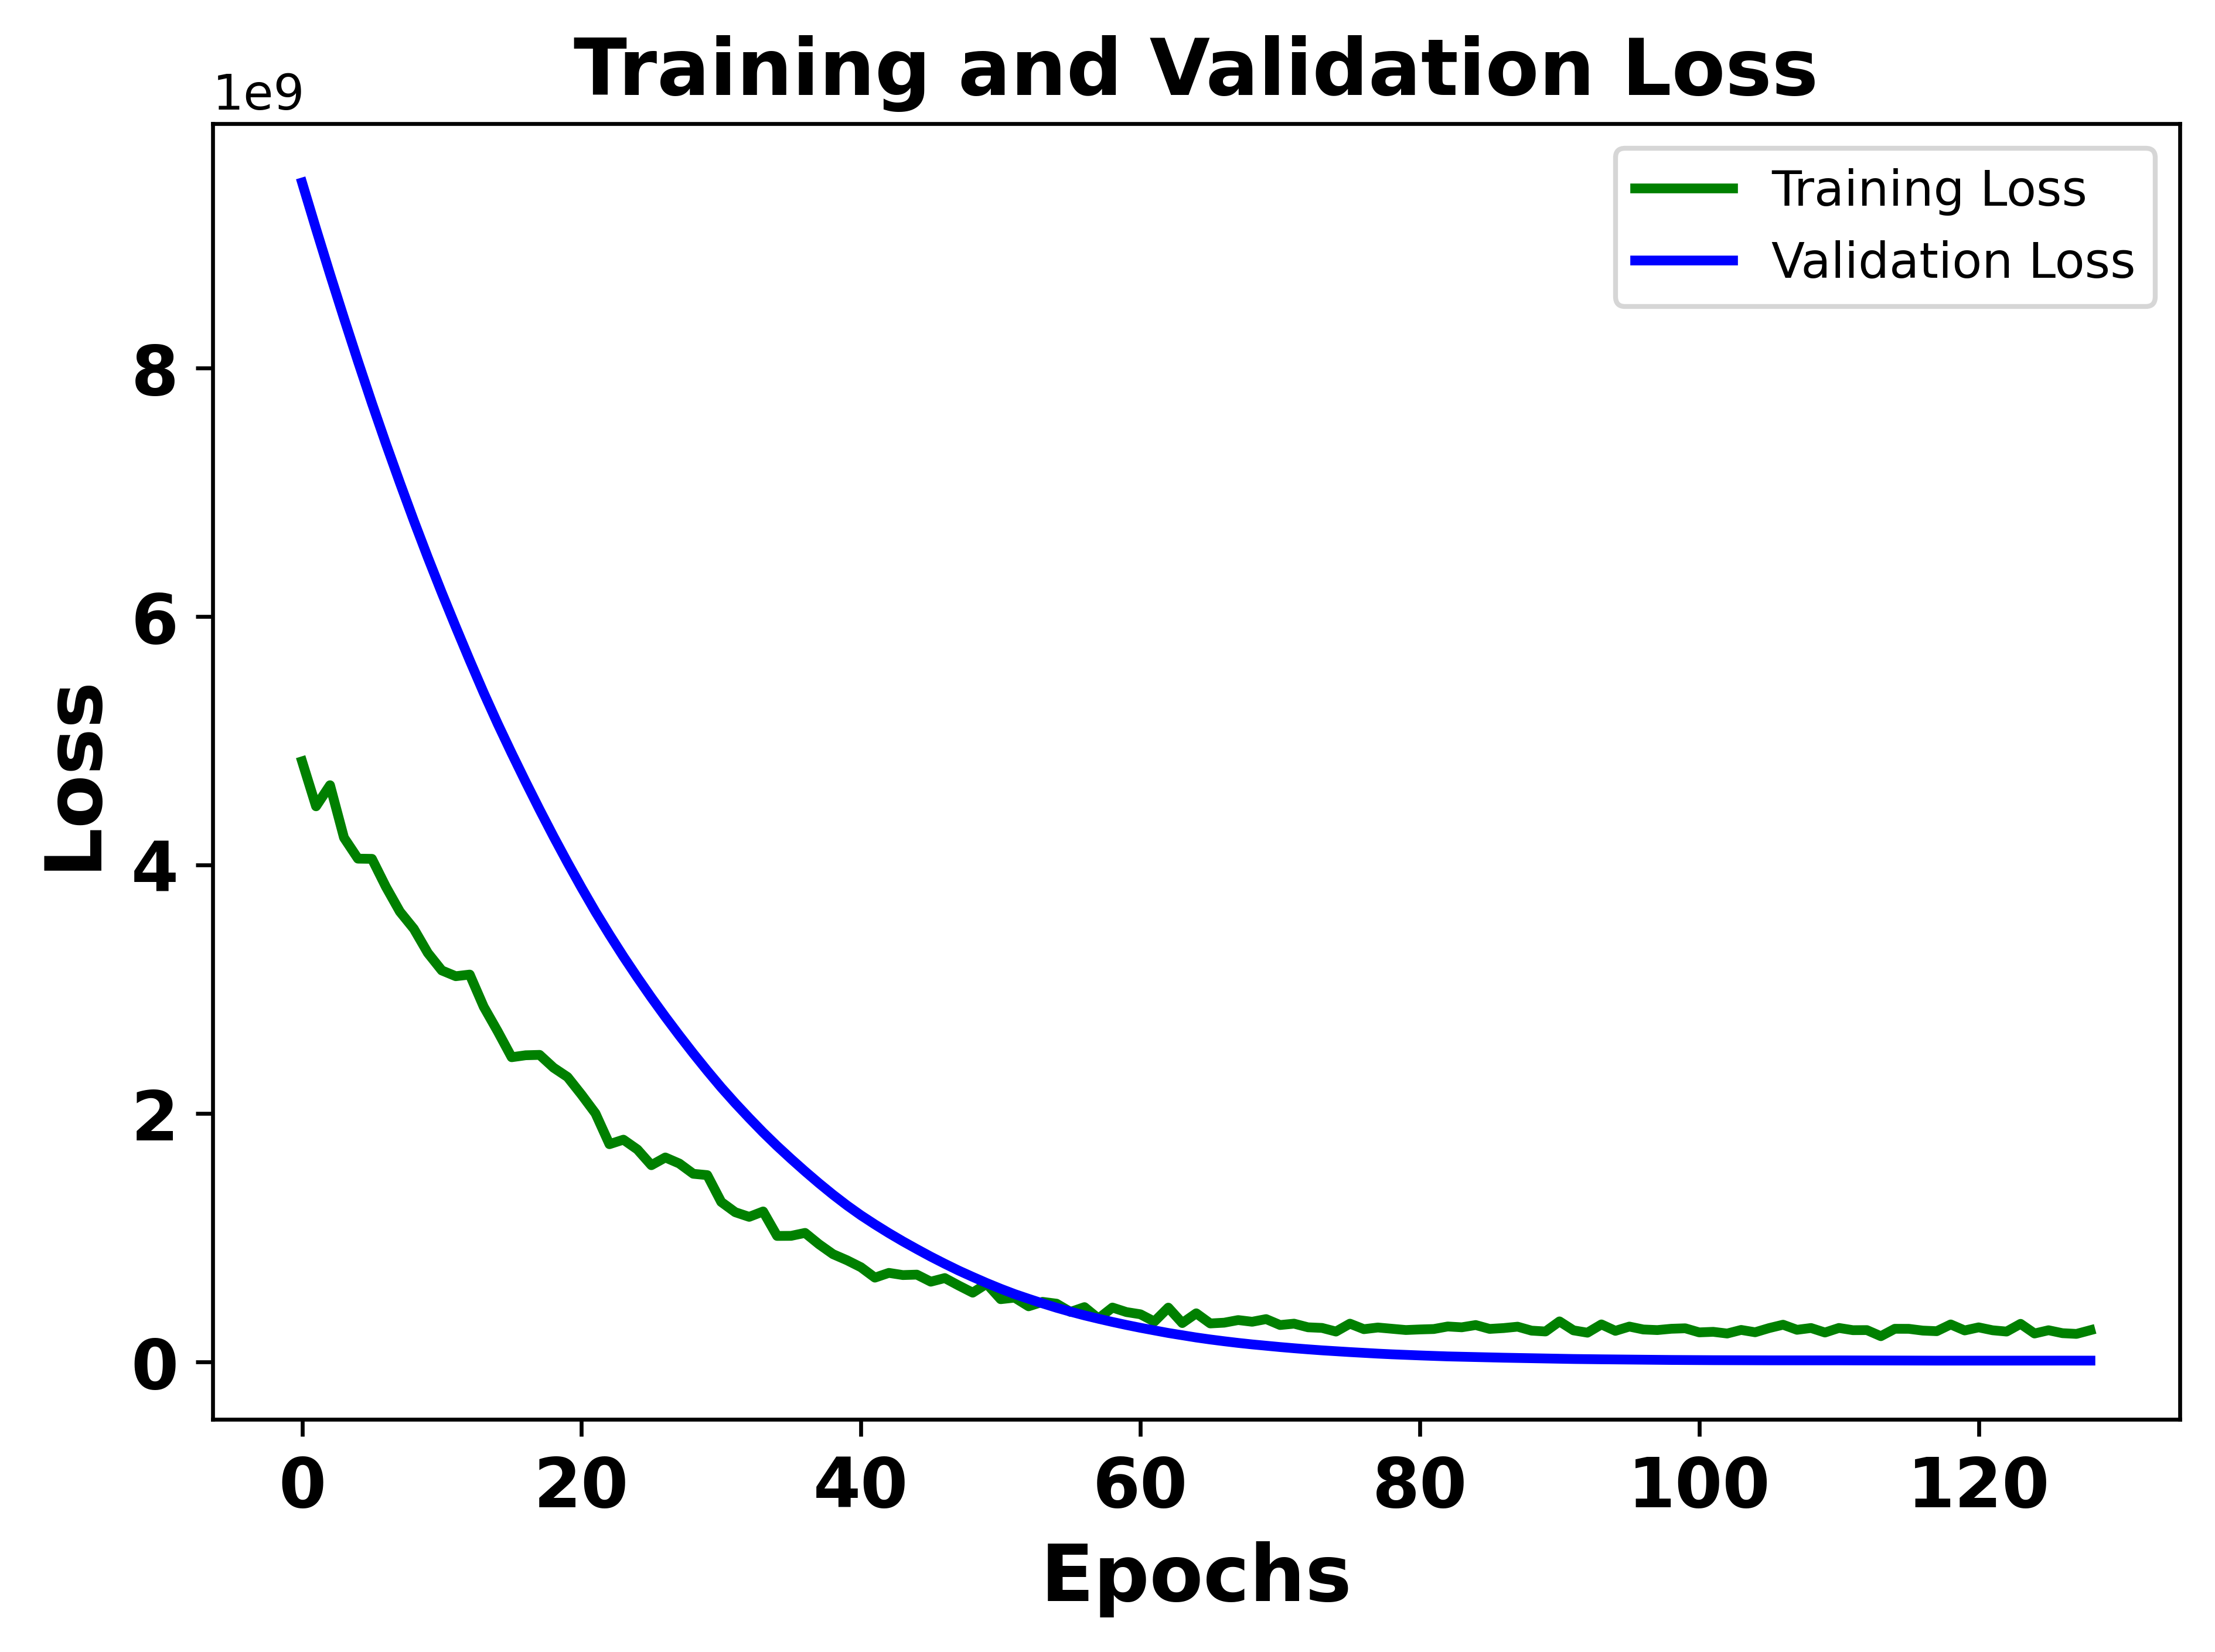

In [ ]:
plot_loss(history, "resources/base_model_loss.jpeg")

Evaluamos el modelo en el conjunto de test:

In [17]:
test_loss = model.evaluate(X_test, y_test, verbose=1, return_dict=True)
pprint(test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 12233517.0000 - mean_absolute_error: 2762.1731
{'loss': 12233517.0, 'mean_absolute_error': 2762.173095703125}


Calculamos las métricas de evaluación:

In [18]:
pred_test = model.predict(X_test)
metrics_dict_test = calculate_metrics(y_test, pred_test)
print("\nTest Set Metrics:")
for metric_name, metric_value in metrics_dict_test.items():
    print(f"Score ({metric_name}): {metric_value}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step

Test Set Metrics:
Score (RMSE): 3497.6447284660085
Score (MAPE): 3.211121646812603
Score (MAE): 2762.1735446428565
Score (MSE): 12233518.646566058
Score (sMAPE): 3.2414109057611826
Score (RRMSE): 4.107703314127866
Score (Quantile Loss): 1381.0867723214283


Finalmente, graficamos para observar los resultados de la predicción:

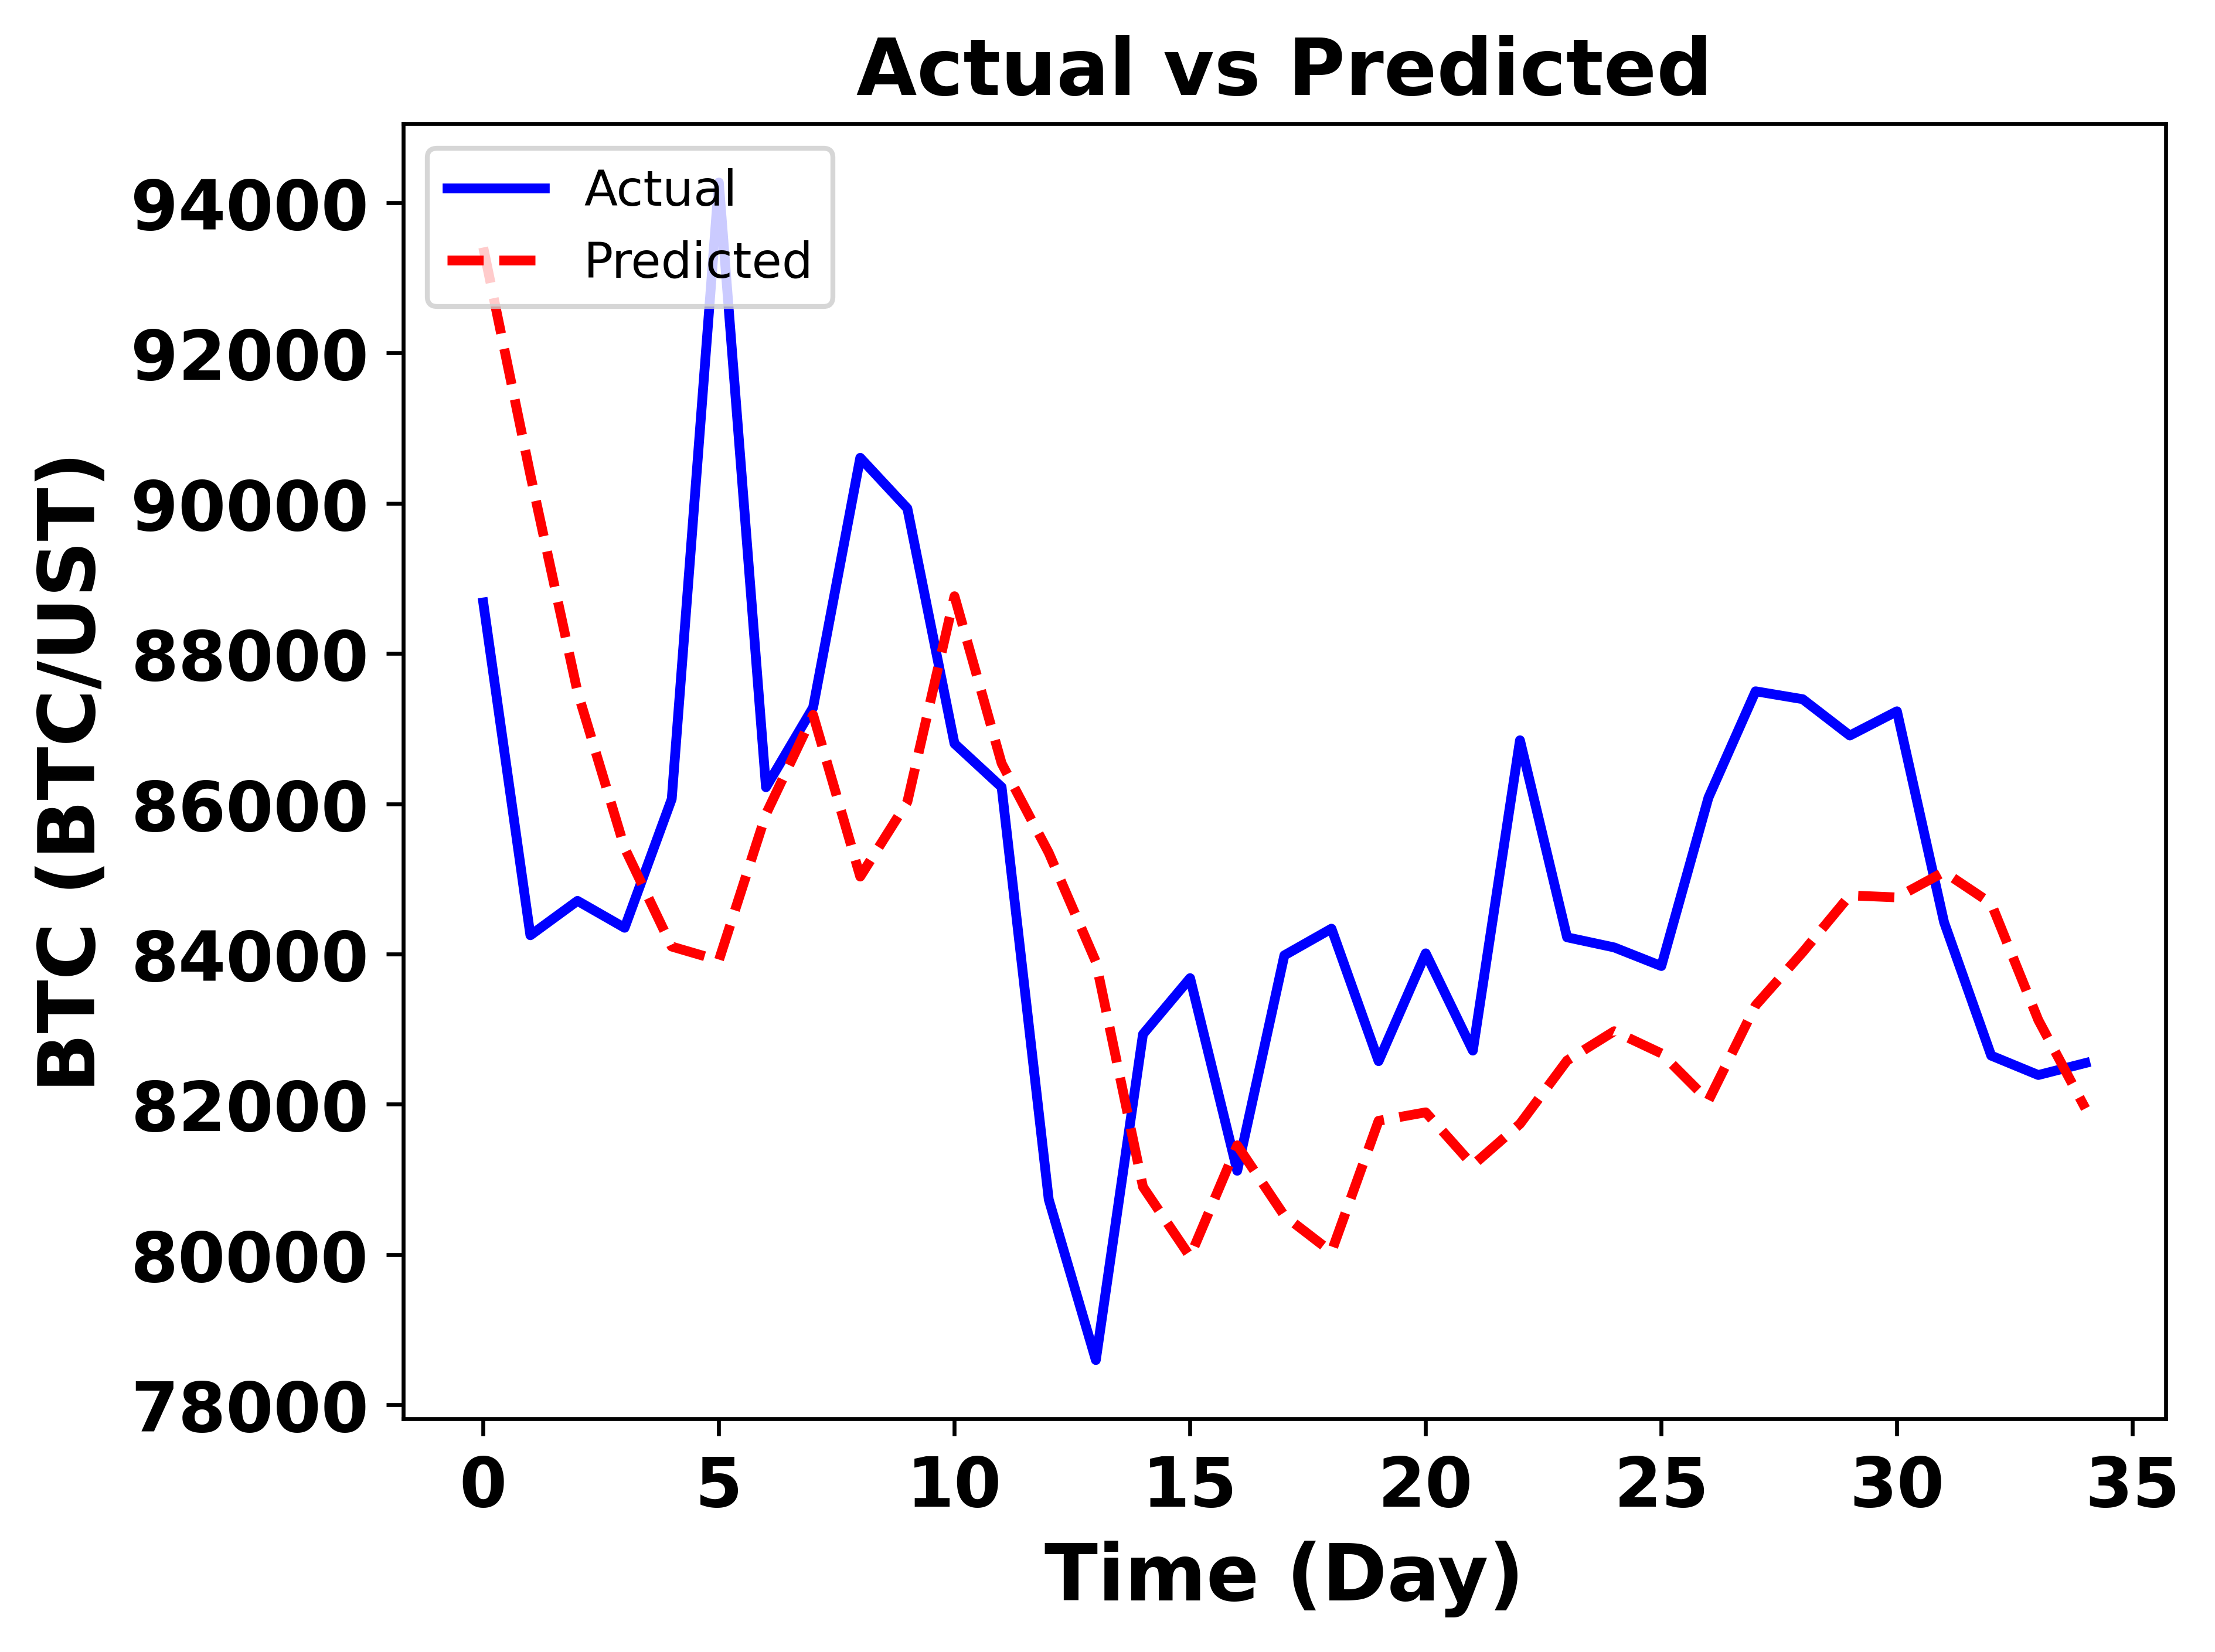

In [ ]:
plot_actual_vs_predicted(y_test, pred_test, "resources/base_model_predict.jpeg")

### 3.2. Transformer + positional encoding <a class="anchor" id="section3_2"></a>

- <small><em>[Making new layers and models via subclassing](https://keras.io/guides/making_new_layers_and_models_via_subclassing/)</small></em>

El objetivo de esta sección es explorar la incorporación de un *positional encoding* alternativo al modelo *Transformer* previamente construido. Este enfoque busca mejorar la capacidad del modelo para capturar patrones temporales en los datos de series de tiempo.
Para ello, se define una nueva clase `PositionalEmbedding` que hereda de `Layer` de *Keras*. Esta clase implementa un *positional encoding* basado en la codificación de las posiciones de los datos en la secuencia. La idea es que entrada del modelo tenga una representación única que permita que éste aprenda patrones temporales de manera más efectiva.

Ejemplo básico de implementación de un `Layer` de Keras:

```python
class Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super().__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return ops.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {"units": self.units}
```

> 💡 <em><font color='IndianRed'>Idea:</font></em> A diferencia de NLP, en donde los tokens son discretos y para estos casos se utiliza la capa `Embedding` de *Keras*, en series de tiempo, los datos son continuos, por lo que para incrustarlos en un espacio de mayor dimensión, probaremos utilizar simplemente una capa `Dense`, en donde el objetivo es que esta capa aprenda a mapear los valores de la serie de tiempo a un espacio dimensional específico (`output_dim`).

Implementación de la clase `PositionalEmbedding`:

In [ ]:
class PositionalEmbedding(Layer):
    """
    Capa de embedding posicional para series de tiempo.

    Args:
        output_dim (int): Dimensión de salida de los embeddings.
        seq_length (int): Longitud de la secuencia de entrada.
        **kwargs: Argumentos adicionales para la clase base Layer.
    """
    def __init__(self, output_dim: int, seq_length: int, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.seq_length = seq_length

    def build(self) -> None:
        self.token_embeddings = Dense(self.output_dim, activation=None)
        self.position_embeddings = Embedding(input_dim=self.seq_length, output_dim=self.output_dim)

    def call(self, inputs):
        positions = np.arange(self.seq_length) # Shape: (batch_size, seq_length) -> (batch_size, seq_length)
        embedded_positions = self.position_embeddings(positions) # Shape: (batch_size, seq_length) -> (batch_size, seq_length, output_dim)
        embedded_tokens = self.token_embeddings(inputs) # Shape: (batch_size, seq_length) -> (batch_size, seq_length, output_dim)
        # Sumar los embeddings posicionales y los embeddings de los tokens
        return embedded_tokens + embedded_positions # Shape: (batch_size, seq_length, output_dim) -> (batch_size, seq_length, output_dim)

    def get_config(self) -> dict:
        config = super().get_config()
        config.update(
            {
                "input_shape": self.input_shape,
                "output_dim": self.output_dim,
            }
        )
        return config

Realizamos un test de verificación:

```python
    inp = Input(shape=(WINDOW_SIZE, 1))
    out = PositionalEmbedding(16)(inp)
    test_model = Model(inputs=inp, outputs=out)
    output = test_model.predict(keras.random.normal(shape=(WINDOW_SIZE, 1)))
```

In [45]:
x = keras.random.normal(shape=(WINDOW_SIZE, 1))
y = PositionalEmbedding(output_dim=8, seq_length=WINDOW_SIZE)(x)
y.shape

TensorShape([5, 8])

Modificamos la función `build_model` para incorporar la nueva capa `PositionalEmbedding`, creando una nueva función auxiliar `build_model_with_positional_embedding`:

In [ ]:
def build_model_with_embeddings(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    seq_length,
    dropout=0,
    mlp_dropout=0,
    embedding_dim=None,
):
    """
    Construye un modelo Transformer para series de tiempo que incorpora una capa de embedding posicional.

    Args:
        input_shape (tuple): Forma de la entrada (longitud de la secuencia, número de características).
        head_size (int): Dimensión de cada cabeza de atención en MultiHeadAttention.
        num_heads (int): Número de cabezas de atención.
        ff_dim (int): Dimensión de la red feed-forward interna de cada bloque Transformer.
        num_transformer_blocks (int): Número de bloques codificadores Transformer a apilar.
        mlp_units (list): Lista con el número de unidades para cada capa densa (MLP) posterior.
        seq_length (int): Longitud de la secuencia de entrada.
        dropout (float, opcional): Tasa de dropout en los bloques Transformer. Por defecto 0.
        mlp_dropout (float, opcional): Tasa de dropout en las capas MLP. Por defecto 0.
        embedding_dim (int, opcional): Dimensión de salida de la capa de embedding. Si no se especifica, se utiliza `head_size`.

    Returns:
        keras.Model: Modelo Keras listo para compilar y entrenar.
    """
    inputs = Input(shape=input_shape) # Shape: (batch_size, sequence_length, num_features) -> (batch_size, sequence_length, num_features)
    x = inputs

    # Determinar la dimensión de embedding:
    # Si embedding_dim no se especifica, usa el `head_size` para que sea consistente con la dimensión de entrada del Transformer.
    if embedding_dim is None:
        embedding_dim = head_size

    x = PositionalEmbedding(output_dim=embedding_dim, seq_length=seq_length)(x) # Shape: (batch_size, sequence_length, num_features) -> (batch_size, sequence_length, embedding_dim)

    # Apilar bloques de codificador Transformer
    for _ in range(num_transformer_blocks):
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout) # Shape: (batch_size, sequence_length, embedding_dim) -> (batch_size, sequence_length, embedding_dim)

    x = GlobalAveragePooling1D()(x) # Shape: (batch_size, sequence_length, embedding_dim) -> (batch_size, embedding_dim)

    # Capa MLP
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x) # Shape: (batch_size, embedding_dim) -> (batch_size, dim)
        x = Dropout(mlp_dropout)(x) # Shape: (batch_size, dim) -> (batch_size, dim)

    outputs = Dense(1)(x) # Shape: (batch_size, dim) -> (batch_size, 1)

    return Model(inputs, outputs)

Creamos el "nuevo" modelo:

In [58]:
input_shape = X_train.shape[1:]
model = build_model_with_embeddings(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    seq_length=WINDOW_SIZE,
    dropout=0.25,
    mlp_dropout=0.4,
    embedding_dim=EMMBEDDING_DIM
)

Mostramos el resumen:

In [56]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 5, 8)      │         56 │ input_layer_4[0]… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 8)      │         16 │ positional_embed… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 8)      │     35,848 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 5, 8)      │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 5, 8)      │          0 │ dropout_14[0][0], │
│                     │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 8)      │         16 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 5, 4)      │         36 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 5, 4)      │          0 │ conv1d_8[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 5, 8)      │         40 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 5, 8)      │          0 │ conv1d_9[0][0],   │
│                     │                   │            │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 8)      │         16 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 8)      │     35,848 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 5, 8)      │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 5, 8)      │          0 │ dropout_17[0][0], │
│                     │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 8)      │         16 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 5, 4)      │         36 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 5, 4)      │          0 │ conv1d_10[0][0] 

 Total params: 145,161 (567.04 KB)

 Trainable params: 145,161 (567.04 KB)

 Non-trainable params: 0 (0.00 B)

Finalmente, compilamos el modelo y lo entrenamos:

In [59]:
model.compile(
    loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-4), metrics=[MeanAbsoluteError()] 
)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=500, batch_size=64, callbacks=CALLBACKS_LIST)

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 4184472320.0000 - mean_absolute_error: 63351.7578 - val_loss: 8374468096.0000 - val_mean_absolute_error: 91445.1953
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3963147264.0000 - mean_absolute_error: 62019.8359 - val_loss: 8178067456.0000 - val_mean_absolute_error: 90365.7500
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3924761856.0000 - mean_absolute_error: 61588.8867 - val_loss: 7984492032.0000 - val_mean_absolute_error: 89289.0625
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3859895552.0000 - mean_absolute_error: 60967.8008 - val_loss: 7792546304.0000 - val_mean_absolute_error: 88208.4609
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3827504128.0000 - mean_absolute_error: 60870.6797 - val_loss: 7603226112.0000 - val_mean_absolute_error: 87129.5156
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3664178176.0000 - mean_absolute_error: 59315.2188 - val_loss: 741821542

Mostramos el progreso del entrenamiento:

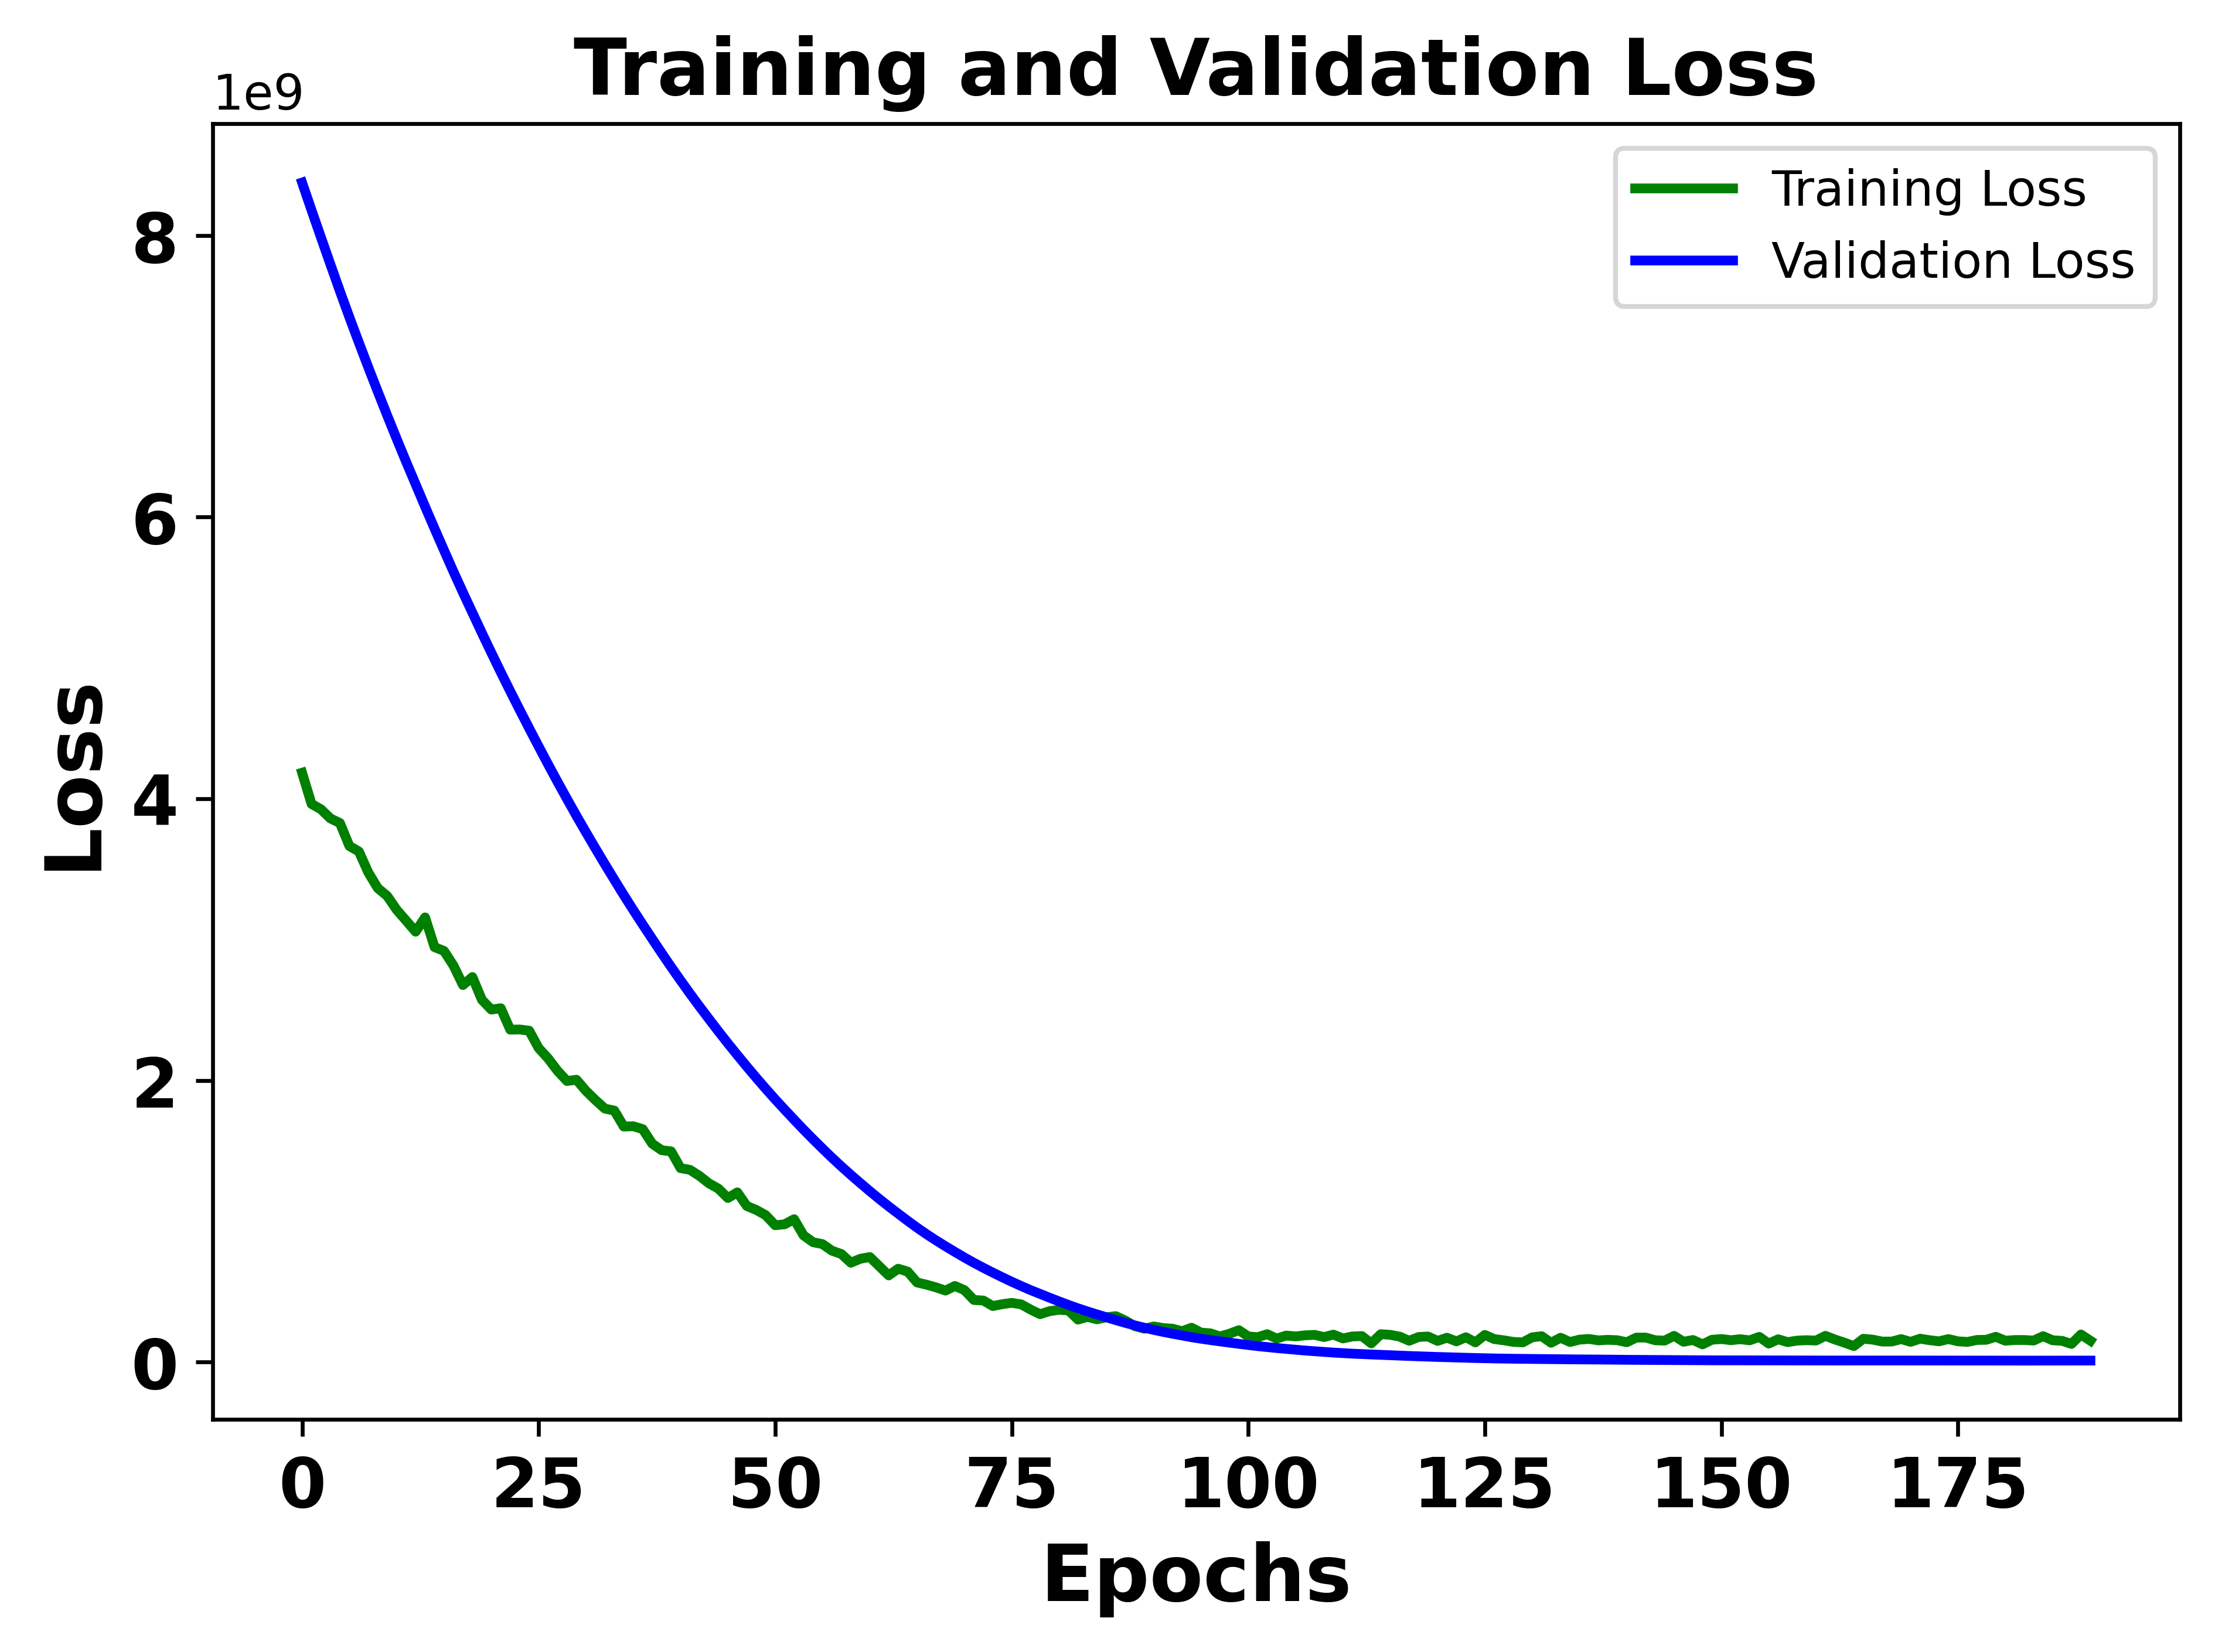

In [60]:
plot_loss(history, "resources/embedding_model_loss.jpeg")

Evaluamos el modelo en el conjunto de test:

In [61]:
test_loss = model.evaluate(X_test, y_test, verbose=1, return_dict=True)
pprint(test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 13558201.0000 - mean_absolute_error: 2877.3071
{'loss': 13558201.0, 'mean_absolute_error': 2877.30712890625}


Calculamos las métricas de evaluación:

In [62]:
pred_test = model.predict(X_test)
metrics_dict_test = calculate_metrics(y_test, pred_test)
print("\nTest Set Metrics:")
for metric_name, metric_value in metrics_dict_test.items():
    print(f"Score ({metric_name}): {metric_value}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step

Test Set Metrics:
Score (RMSE): 3682.1464503381817
Score (MAPE): 3.3575945707272523
Score (MAE): 2877.3074017857134
Score (MSE): 13558202.481738072
Score (sMAPE): 3.3572102696955644
Score (RRMSE): 4.324385794263295
Score (Quantile Loss): 1438.6537008928567


Realizamos la predicción y graficamos los resultados:

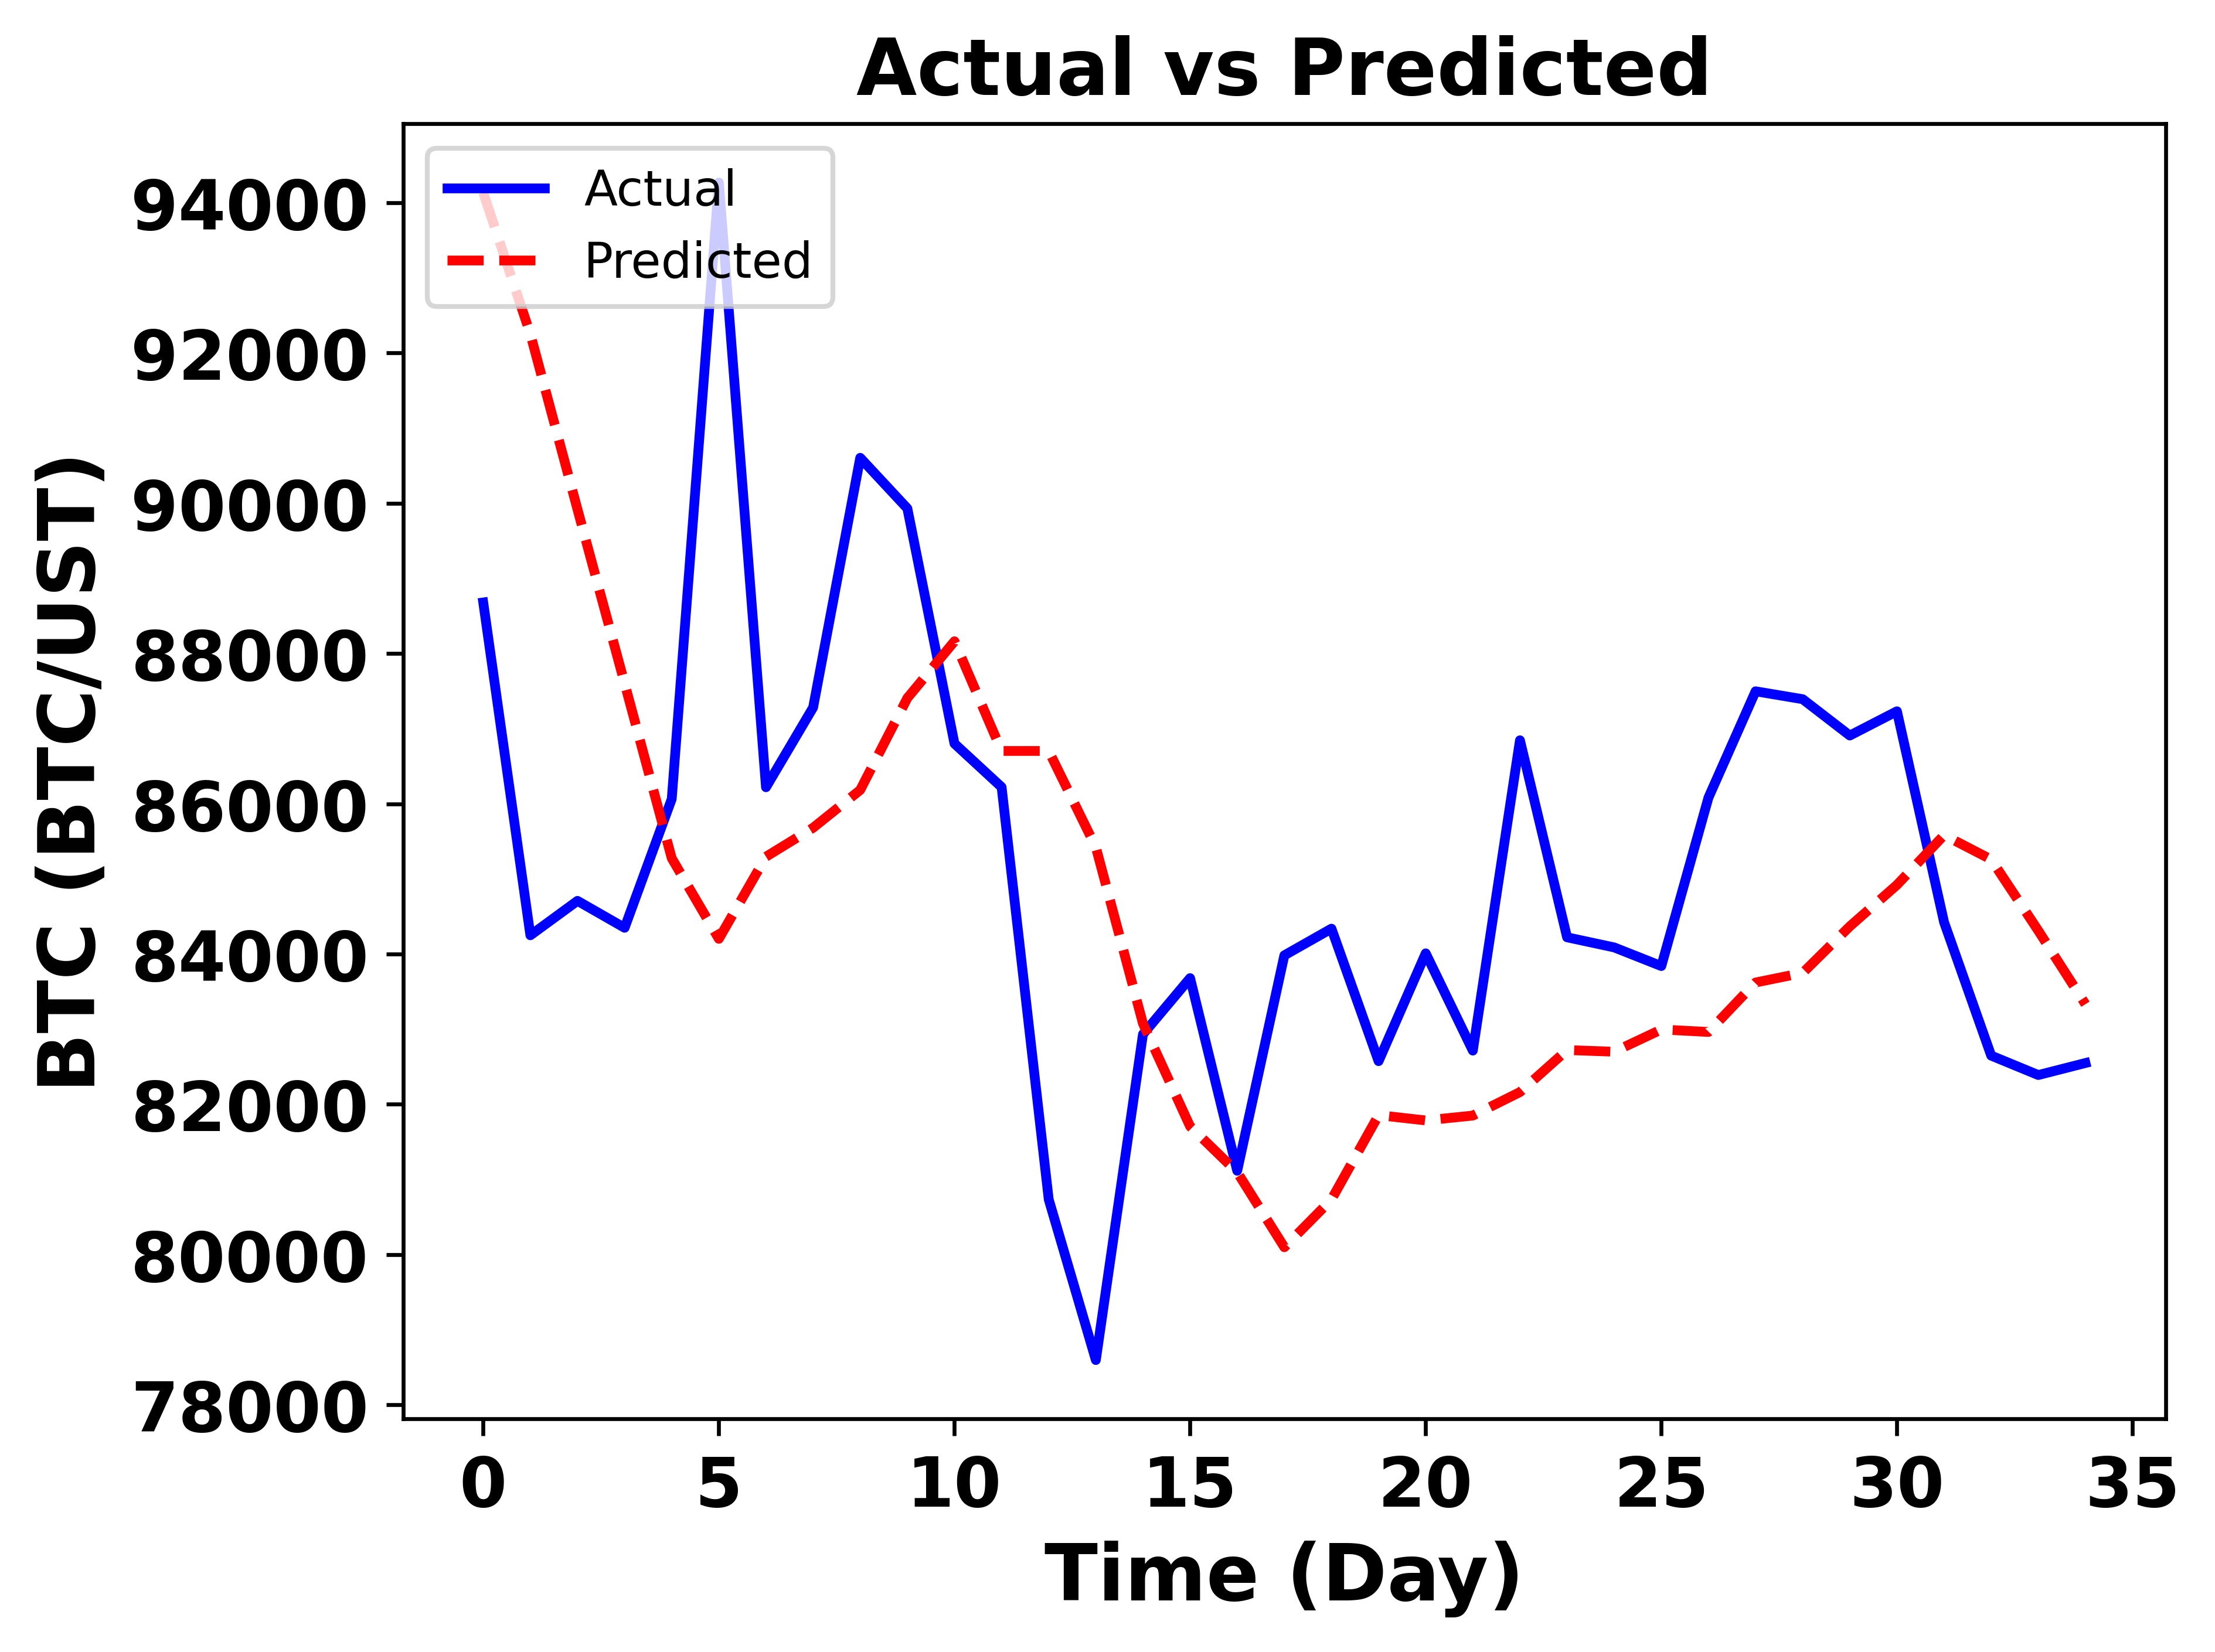

In [63]:
plot_actual_vs_predicted(y_test, pred_test, "resources/embbeding_model_predict.jpeg")

## 4. Estado del arte <a class="anchor" id="chapter4"></a>

### 4.1. Caso de uso: Informer <a class="anchor" id="section_4_1"></a>

## 5. Conclusiones <a class="anchor" id="chapter5"></a>